In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dataset_path = '/content/drive/My Drive/Dataset/imgs'
os.chdir(dataset_path)

In [ ]:
dirlist = ['../imgs/health/', '../imgs/sick/', '../imgs/tb']
classes = ['Healthy', 'Sick', 'Tuberculosis']
filepaths = []
labels = []
for d, c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  8408    labels:  8408


In [ ]:
Fseries = pd.Series(filepaths, name='file_paths')
Lseries = pd.Series(labels, name='labels')

# Ensure lengths match
min_length = min(len(Fseries), len(Lseries))
Fseries = Fseries[:min_length]
Lseries = Lseries[:min_length]

# Create the DataFrame with named columns
df = pd.concat([Fseries, Lseries], axis=1)
df.columns = ['file_paths', 'labels']

# Count occurrences of each label
label_counts = df['labels'].value_counts()
print(label_counts)

Healthy         3814
Sick            3809
Tuberculosis     785
Name: labels, dtype: int64


In [ ]:
file_count = 1500
samples = []

for category in df['labels'].unique():
    category_slice = df.query("labels == @category")

    if len(category_slice) < file_count:
        # If the number of files in the category is less than file_count,
        # sample with replacement to fill up the required number of samples
        samples.append(category_slice.sample(file_count, replace=True, random_state=1))
    else:
        samples.append(category_slice.sample(file_count, replace=False, random_state=1))

df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print(df['labels'].value_counts())
print(len(df))

Sick            1500
Healthy         1500
Tuberculosis    1500
Name: labels, dtype: int64
4500


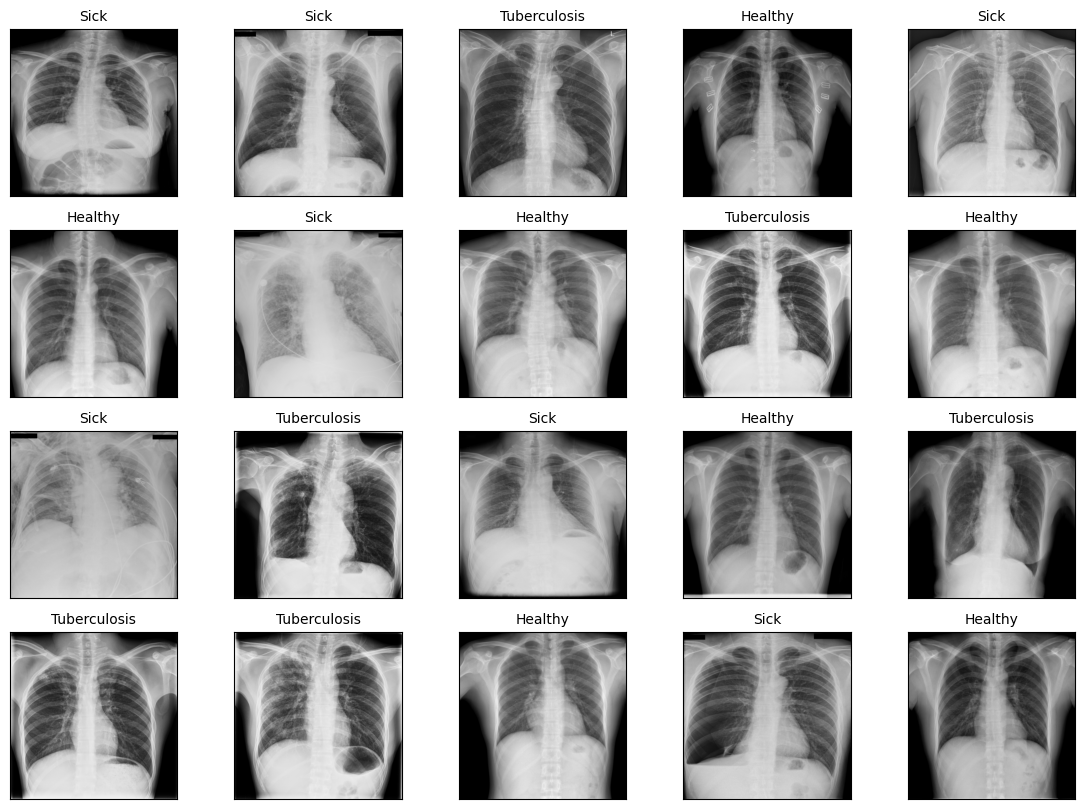

In [ ]:
plt.figure(figsize=(14,10))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    img = df.loc[random,"file_paths"]
    plt.imshow(plt.imread(img))
    plt.title(df.loc[random, "labels"], size = 10, color = "black")
    plt.xticks([])
    plt.yticks([])


plt.show()

In [ ]:
def split_data(df, train_size=0.7, valid_size=0.15, test_size=0.15, random_state=None):
    """
    Split the data into training, validation, and test sets.

    Parameters:
    - df: DataFrame containing the data to be split.
    - train_size: The proportion of data to include in the training set (default: 0.7).
    - valid_size: The proportion of data to include in the validation set (default: 0.15).
    - test_size: The proportion of data to include in the test set (default: 0.15).
    - random_state: Seed for random number generation (optional).

    Returns:
    - train_df: DataFrame for training.
    - valid_df: DataFrame for validation.
    - test_df: DataFrame for testing.
    """
    if train_size + valid_size + test_size != 1.0:
        raise ValueError("The sum of train_size, valid_size, and test_size should be 1.0")

    # Split the data into training and test sets
    train_and_valid_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Further split the training and validation data
    train_df, valid_df = train_test_split(train_and_valid_df,
                                          train_size=train_size / (train_size + valid_size),
                                          random_state=random_state)

    return train_df, valid_df, test_df

def print_label_counts(df, set_name):
    """
    Print label counts for a given DataFrame.

    Parameters:
    - df: DataFrame for which label counts should be printed.
    - set_name: Name of the data set (e.g., "Training", "Validation", "Test").
    """
    print(f"{set_name} Set Label Counts:")
    label_counts = df['labels'].value_counts()
    print(label_counts)

# Split the data into train, validation, and test sets
train_df, valid_df, test_df = split_data(df, train_size=0.7, valid_size=0.15, test_size=0.15, random_state=0)

# Print label counts for each set
print_label_counts(train_df, "Training")
print_label_counts(valid_df, "Validation")
print_label_counts(test_df, "Test")


Training Set Label Counts:
Sick            1066
Healthy         1044
Tuberculosis    1040
Name: labels, dtype: int64
Validation Set Label Counts:
Healthy         233
Tuberculosis    229
Sick            213
Name: labels, dtype: int64
Test Set Label Counts:
Tuberculosis    231
Healthy         223
Sick            221
Name: labels, dtype: int64


In [ ]:
# Define target size and batch size
target_size = (224, 224)
batch_size = 4

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
train_gen = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', class_mode='categorical')

Found 3150 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.
Found 675 validated image filenames belonging to 3 classes.


a

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50  # Import ResNet50

# Define the backbone network (ResNet-50)
base_model = ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Define the region proposal network (RPN)
# This is a simplified version for demonstration purposes
# In practice, you would use a pre-trained RPN or custom implementation
rpn_input = base_model.output
rpn_output = Conv2D(256, (3, 3), activation='relu')(rpn_input)
rpn_output = MaxPooling2D(pool_size=(2, 2))(rpn_output)
rpn_output = Flatten()(rpn_output)
rpn_output = Dense(256, activation='relu')(rpn_output)

# Create the Fast R-CNN model
fast_rcnn_input = Input(shape=(224, 224, 3))  # Specify the input shape
roi_pooling_layer = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)  # Use the correct layer name
roi_pooled_features = roi_pooling_layer(fast_rcnn_input)

fast_rcnn_output = GlobalAveragePooling2D()(roi_pooled_features)
fast_rcnn_output = Dense(128, activation='relu')(fast_rcnn_output)
fast_rcnn_output = tf.keras.layers.BatchNormalization()(fast_rcnn_output)
fast_rcnn_output = tf.keras.layers.Dropout(0.2)(fast_rcnn_output)
fast_rcnn_output = Dense(3, activation='softmax')(fast_rcnn_output)

fast_rcnn_model = Model(inputs=fast_rcnn_input, outputs=fast_rcnn_output)

# Optional: You may want to freeze the weights of the backbone network
for layer in base_model.layers:
    layer.trainable = False

# Compile the Fast R-CNN model with an appropriate loss and optimizer
fast_rcnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the Fast R-CNN model
fast_rcnn_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_2 (Functional)        (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0   

In [ ]:
# Define the number of training steps and validation steps
train_steps_per_epoch = len(train_gen)
valid_steps_per_epoch = len(valid_gen)

# Define the number of epochs
num_epochs = 10  # You can adjust this as needed

# Fit the Fast R-CNN model
history = fast_rcnn_model.fit_generator(
    train_gen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=num_epochs,
    validation_data=valid_gen,
    validation_steps=valid_steps_per_epoch
)

# Evaluate the model on the test set
test_results = fast_rcnn_model.evaluate(test_gen)

# Print test results (e.g., test loss and test accuracy)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


Epoch 1/10


<ipython-input-18-15a80be3ba21>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = fast_rcnn_model.fit_generator(


788/788 [==============================] - 938s 1s/step - loss: 0.5445 - accuracy: 0.7844 - val_loss: 0.2124 - val_accuracy: 0.9156
Epoch 2/10
788/788 [==============================] - 802s 1s/step - loss: 0.4267 - accuracy: 0.8413 - val_loss: 0.1652 - val_accuracy: 0.9422
Epoch 3/10
788/788 [==============================] - 807s 1s/step - loss: 0.3982 - accuracy: 0.8505 - val_loss: 0.1628 - val_accuracy: 0.9437
Epoch 4/10
788/788 [==============================] - 798s 1s/step - loss: 0.3967 - accuracy: 0.8473 - val_loss: 0.1498 - val_accuracy: 0.9496
Epoch 5/10
788/788 [==============================] - 800s 1s/step - loss: 0.3821 - accuracy: 0.8517 - val_loss: 0.1204 - val_accuracy: 0.9630
Epoch 6/10
788/788 [==============================] - 805s 1s/step - loss: 0.3519 - accuracy: 0.8654 - val_loss: 0.1572 - val_accuracy: 0.9526
Epoch 7/10
788/788 [==============================] - 800s 1s/step - loss: 0.3558 - accuracy: 0.8711 - val_loss: 0.1189 - val_accuracy: 0.9585
Epoch 8/10

In [ ]:
fast_rcnn_model.save("resnet50.h5")